In [1]:
# prepare the runtime workspace: install, import, download
!pip install brian2

In [2]:
!pip install brian2tools

In [3]:
from brian2tools import *

from IPython.display import display
import brian2.numpy_ as np # the numpy that comes bundled with it
from ipywidgets import interact, interactive # for some neat interactions
from IPython.display import display 
import ipywidgets as widgets
import matplotlib.pyplot as plt # for neat plots
import matplotlib.gridspec as gridspec

import time # for time basis conversions

In [96]:

from brian2 import *
def cell_morpho(num_dendrites,som_diameter, den_diameter, den_length, axn_diameter, axn_length):
    name_compartments = ["" for x in range(num_dendrites+1)]
    name_compartments[0] = 'IO_axon'
    for i in range(1,num_dendrites+1):
        name_compartments[i] = 'IO_den'+str(i)

    IO_morpho = Soma(diameter=som_diameter)
    IO_morpho[name_compartments[0]] = Cylinder(length=axn_length, diameter=axn_diameter, n=1)
    for ii in range(1,num_dendrites+1):
        IO_morpho[name_compartments[ii]] = Cylinder(length=den_length, diameter=den_diameter, n=1)
    return IO_morpho

def IO_equations():
	eqs_IO_V = '''
	Im = (-(I_l + I_Na + I_prot + I_K_dr + I_h + I_K_s + I_Ca_h + I_K_Ca + I_c + I_K_a + I_Na_a)) : metre**-2*amp
	I_c : metre**-2*amp
	Iapp : amp (point current)
	'''
	eqs_IO_Ca = '''
	dCa/dt = (-3*I_Ca_h*((uamp / cm**2)**-1)*mM - 0.075*Ca)/ms : mM
	'''
	eqs_IO_Isom = '''
	I_l    = g_l*(v-V_l)              : metre**-2*amp
	I_Na    = g_Na*m_inf**3*h*(v-V_Na)  : metre**-2*amp
	I_Ca_l  = g_Ca_l*k*k*k*l*(v-V_Ca)   : metre**-2*amp
	I_K_dr  = g_Kdr*n*n*n*n*(v-V_K)     : metre**-2*amp
	I_h     = g_h*q*(v-V_h)             : metre**-2*amp
	I_K_s   = g_K_s*(x_s**4)*(v-V_K)    : metre**-2*amp

	I_prot = g_prot*k_prot*l_prot*(v-V_prot)   : metre**-2*amp
	'''
	eqs_IO_Iden = '''
	I_Ca_h  = g_Ca_h*r*r*(v-V_Ca)       : metre**-2*amp
	I_K_Ca  = g_K_Ca*s*(v-V_K)          : metre**-2*amp
    
	'''
    #I_Cl_Ca  = g_Cl_Ca*m_cl*(v-V_Cl_Ca) : metre**-2*amp
	eqs_IO_Iax = '''
	I_K_a  = g_K_a *x_a**4*(v-V_K)      : metre**-2*amp
	I_Na_a = g_Na_a*m_a**3*h_a*(v-V_Na) : metre**-2*amp
	'''
	eqs_IO_activation = '''
	dh/dt = (h_inf - h)/tau_h : 1
	dk/dt = (k_inf - k)/tau_k : 1
	dl/dt = (l_inf - l)/tau_l : 1
	dn/dt = (n_inf - n)/tau_n : 1
	dq/dt = (q_inf - q)/tau_q : 1
	dr/dt = (r_inf - r)/tau_r : 1
	ds/dt = (s_inf - s)/tau_s : 1
	m_a = m_inf_a : 1
	dh_a/dt = (h_inf_a - h_a)/tau_h_a : 1
	dx_a/dt = (x_inf_a - x_a)/tau_x_a : 1
	dx_s/dt = (x_inf_s - x_s)/tau_x_s : 1
    
	dk_prot/dt = (k_inf_prot - k_prot)/tau_k_prot : 1
	dl_prot/dt = (l_inf_prot - l_prot)/tau_l_prot : 1
    
	'''
    #m_cl = m_cl_inf : 1
	eqs_IO_inf = '''
	m_inf   = alpha_m /(alpha_m+beta_m)        : 1
	h_inf   = alpha_h/(alpha_h+beta_h)         : 1
	k_inf   = 1/(1+e**(-(v/mvolt+61)/4.2))    : 1
	l_inf   = 1/(1+e**((v/mvolt+85.5)/8.5))   : 1
	n_inf   = alpha_n/(alpha_n+beta_n)         : 1
	q_inf   = 1/(1+e**((v/mvolt+75)/(5.5)))   : 1
	r_inf   = alpha_r/(alpha_r + beta_r)       : 1
	s_inf   = alpha_s/(alpha_s+beta_s)         : 1
	m_inf_a = 1/(1+(e**((-30-v/mvolt)/ 5.5))) : 1
	h_inf_a = 1/(1+(e**((-60-v/mvolt)/-5.8))) : 1
	x_inf_a = alpha_x_a/(alpha_x_a+beta_x_a)   : 1
	x_inf_s = alpha_x_s/(alpha_x_s + beta_x_s) : 1
    
	k_inf_prot   = 1/(1+e**((v/mV-(-72.91))/(4.58))) : 1
	l_inf_prot   = 1/(1+e**((v/mV-(-42.92))/(-5.16)))  : 1
    
	'''
    #m_cl_inf = 1/(1+(e**(((0.37)-(Ca/uM))/0.09))) : 1
	eqs_IO_tau = '''
	tau_h   = 170*msecond/(alpha_h+beta_h)                                          : second
	tau_k   = 5*msecond                                                             : second
	tau_l   = 1*msecond*(35+(20*e**((v/mvolt+160)/30/(1+e**((v/mvolt+84)/7.3))))) : second
	tau_n   = 5*msecond/(alpha_n+beta_n)                                            : second
	tau_q   = 1*msecond/(e**((-0.086*v/mvolt-14.6))+e**((0.07*v/mvolt-1.87)))     : second
	tau_r   = 5*msecond/(alpha_r + beta_r)                                          : second
	tau_s   = 1*msecond/(alpha_s + beta_s)                                          : second
	tau_h_a = 1.5*msecond*e**((-40-v/mvolt)/33)                                    : second
	tau_x_a = 1*msecond/(alpha_x_a + beta_x_a)                                      : second
	tau_x_s = 1*msecond/(alpha_x_s + beta_x_s)                                      : second

	tau_k_prot   = 9.99*ms + (0.002883*ms * e**(-v/mvolt/5.599)) : second
	tau_l_prot   =-0.856*ms + (1.494*ms * e**(-v/mvolt/(27.41))) : second

	'''
	eqs_IO_alpha = '''
	alpha_m   = (0.1*(v/mvolt + 41))/(1-e**(-(v/mvolt+41)/10)) : 1
	alpha_h   = 5.0*e**(-(v/mvolt+60)/15) : 1
	alpha_n   = (v/mvolt + 41)/(1-e**(-(v/mvolt+41)/10)) : 1
	alpha_r   = 1.7/(1+e**(-(v/mvolt - 5)/13.9)) : 1
	alpha_s   = ((0.00002*Ca/mM)*int((0.00002*Ca/mM)<0.01) + 0.01*int((0.00002*Ca/mM)>=0.01)) : 1
	alpha_x_a = 0.13*(v/mvolt + 25)/(1-e**(-(v/mvolt+25)/10)) : 1
	alpha_x_s = 0.13*(v/mvolt + 25)/(1-e**(-(v/mvolt+25)/10)) : 1
	'''

	eqs_IO_beta = '''
	beta_m = 9.0*e**(-(v/mvolt+60)/20)                        : 1
	beta_h = (v/mvolt+50)/(1-e**(-(v/mvolt+50)/10))          : 1
	beta_n = 12.5*e**(-(v/mvolt+51)/80)                       : 1
	beta_r = 0.02*(v/mvolt + 8.5)/(e**((v/mvolt + 8.5)/5)-1) : 1
	beta_s = 0.015                                             : 1
	beta_x_a  = 1.69*e**(-0.0125*(v/mvolt + 35))              : 1
	beta_x_s  = 1.69*e**(-0.0125*(v/mvolt+ 35))               : 1
	'''

	eqs_vector = '''
	V_Na : volt
	V_K  : volt
	V_Ca : volt
	V_l  : volt
	V_h  : volt
	V_prot  : volt
	
	g_Na   : siemens/meter**2
	g_Kdr  : siemens/meter**2
	g_Ca_l : siemens/meter**2
	g_h    : siemens/meter**2
	g_Ca_h : siemens/meter**2
	g_K_Ca : siemens/meter**2
	g_l     : siemens/meter**2
	g_Na_a  : siemens/meter**2
	g_K_a   : siemens/meter**2
	g_K_s   : siemens/meter**2
    
	g_prot : siemens/meter**2
	
	'''
    #g_Cl_Ca : siemens/meter**2
    #V_Cl_Ca : volt

	eqs_IO = eqs_IO_beta
	eqs_IO += eqs_IO_alpha
	eqs_IO += eqs_IO_tau
	eqs_IO += eqs_IO_inf
	eqs_IO += eqs_IO_activation
	eqs_IO += eqs_IO_Iax
	eqs_IO += eqs_IO_Iden
	eqs_IO += eqs_IO_Isom
	eqs_IO += eqs_IO_Ca
	eqs_IO += eqs_IO_V
	eqs_IO += eqs_vector
	return eqs_IO


def cell_values(IO):
	### Dendrites
	IO.V_Na = 0.0*mvolt
	IO.V_K = -75*mvolt
	IO.V_Ca = 120*mvolt
	IO.V_l = 10*mvolt 
	IO.V_h = 0.0*mvolt
	IO.V_prot = 30*mvolt
#	IO.V_Cl_Ca = -45*mvolt    
	IO.g_Na = 0.0*mS/cm**2 
	IO.g_Ca_l =  0.0*mS/cm**2
	IO.g_Kdr = 0.0*mS/cm**2
	IO.g_K_s= 0.0*mS/cm**2
	IO.g_h = 0.0*mS/cm**2 
	IO.g_Ca_h = 4.5*mS/cm**2 #4.5
	IO.g_K_Ca = 35*mS/cm**2
	IO.g_Na_a = 0.0*mS/cm**2
	IO.g_K_a = 0.0*mS/cm**2
	IO.g_l = 0.016*mS/cm**2
	IO.g_prot =  0.0*mS/cm**2    
#	IO.g_Cl_Ca = 0.0mS/cm**2
	### Soma
	IO.main.V_Na = 55*mvolt
	IO.main.V_K = -75*mvolt
	IO.main.V_Ca = 120*mvolt
	IO.main.V_l = 10*mvolt 
	IO.main.V_h = -43*mvolt
	IO.main.V_prot = 30*mvolt
#	IO.main.V_Cl_Ca = 0.0*mvolt
	IO.main.g_Na = 70*mS/cm**2 #150
	IO.main.g_Ca_l =  2.5*mS/cm**2
	IO.main.g_Kdr = 9.0*mS/cm**2
	IO.main.g_h = 1.5*mS/cm**2 #0.12
	IO.main.g_K_s = 5.0*mS/cm**2
	IO.main.g_Ca_h = 0.0*mS/cm**2 #4.5
	IO.main.g_K_Ca = 0.0*mS/cm**2
	IO.main.g_Na_a = 0.0*mS/cm**2
	IO.main.g_K_a = 0.0*mS/cm**2
	IO.main.g_l = 0.016*mS/cm**2
	IO.main.g_prot =  2.5*mS/cm**2
#	IO.main.g_Cl_Ca = 0.0*mS/cm**2
	### Axon
	IO.IO_axon.V_Na = 55*mvolt
	IO.IO_axon.V_K = -75*mvolt
	IO.IO_axon.V_Ca = 0.0*mvolt
	IO.IO_axon.V_l = 10*mvolt 
	IO.IO_axon.V_h = 0.0*mvolt
	IO.IO_axon.V_prot = 0.0*mvolt
#	IO.IO_axon.V_Cl_Ca = 0.0*mvolt
	IO.IO_axon.g_Na = 0.0*mS/cm**2 
	IO.IO_axon.g_Ca_l =  0.0*mS/cm**2
	IO.IO_axon.g_Kdr = 0.0*mS/cm**2
	IO.IO_axon.g_K_s = 0.0*mS/cm**2
	IO.IO_axon.g_h = 0.0*mS/cm**2 
	IO.IO_axon.g_Ca_h = 0.0*mS/cm**2 
	IO.IO_axon.g_K_Ca = 0.0*mS/cm**2
	IO.IO_axon.g_Na_a = 120*mS/cm**2
	IO.IO_axon.g_K_a = 10*mS/cm**2
	IO.IO_axon.g_l = 0.016*mS/cm**2
	IO.IO_axon.g_prot =  0.0*mS/cm**2    
#	IO.IO_axon.g_Cl_Ca = 0.0*mS/cm**2
	return IO

def plot_membrane_potentials_IO(IO_Statemon,num_dendrites):
	figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='k')
	plt.subplot(3, 1, 1)
	for ii in range(0,1):
	  plot(IO_Statemon.t/ms,IO_Statemon.v[ii]/(mvolt),label='Soma')
	title('Soma Voltage')
	# xlabel('Time [ms]')
	ylabel('v [mV]')
	ylim([-100,100])
	plt.subplot(3, 1, 2)
	for ii in range(2,num_dendrites+2):
	  plot(IO_Statemon.t/ms,IO_Statemon.v[ii]/(mvolt),label='Dendrite'+str(ii-1))
	title('Dendrite Voltage')
	# xlabel('Time [ms]')
	ylabel('v [mV]')
	ylim([-100,100])
	plt.subplot(3, 1, 3)
	for ii in range(1,2):
	  plot(IO_Statemon.t/ms,IO_Statemon.v[ii]/(mvolt),label='Axon')
	title('Axon Voltage')
	xlabel('Time [ms]')
	ylabel('v [mV]')
	ylim([-100,100])
	legend()
	show()
    


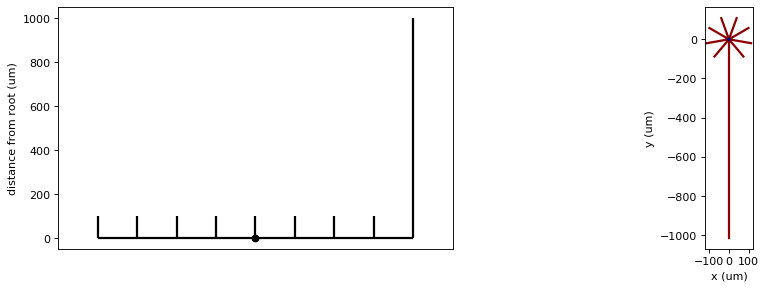

In [97]:
start_scope()

##### Dimensions of the compartments 
som_diameter = 30*um #Soma
den_diameter = 2*um #Dendrites
den_length = 100*um #Dendrites
axn_diameter = 1*um #Axon
axn_length = 1000*um #Axon

##### Choose the number of dendrites
num_dendrites = 8

#### Create Morphology
IO_morpho = cell_morpho(num_dendrites,som_diameter, den_diameter, den_length, axn_diameter, axn_length)

IO_morpho_new = IO_morpho.generate_coordinates()

figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
brian_plot(IO_morpho) 
plt.subplot(1, 2, 2)
plot_morphology(IO_morpho_new, plot_3d=False)

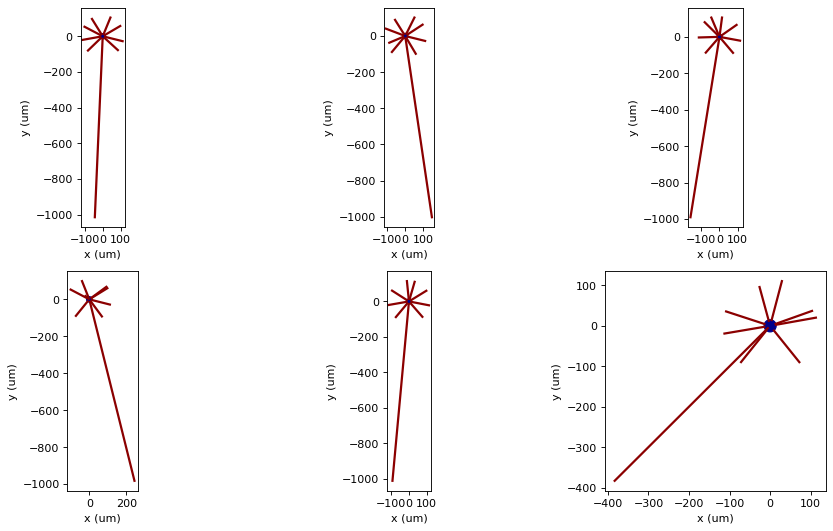

In [98]:
IO_mor = [[]]*6
for i in range(0,6):
  IO_mor[i] = IO_morpho.generate_coordinates(section_randomness=30)

figure(figsize=(14, 8), dpi= 80, facecolor='w', edgecolor='k')
for i in range(0,6):
  plt.subplot(2, 3, i+1)
  plot_morphology(IO_mor[i], plot_3d=False)

In [99]:
dt = 0.025*ms
dt_rec = 0.25*ms

eqs_IO = IO_equations()

IO = SpatialNeuron(morphology=IO_morpho, model = eqs_IO, Cm=1 *uF*cm**-2 , Ri=100.0*ohm*cm, method="exponential_euler", name = 'SchweighoferOlive', dt=dt)
IO_Statemon = StateMonitor(IO, variables = ['Im', 'v', 'Ca', 'Iapp', 'k','l','k_prot','l_prot', 'I_Ca_l', 'I_prot'], record = True, dt=dt_rec)
store('IO_setup')
print('State Stored as IO_setup')

State Stored as IO_setup


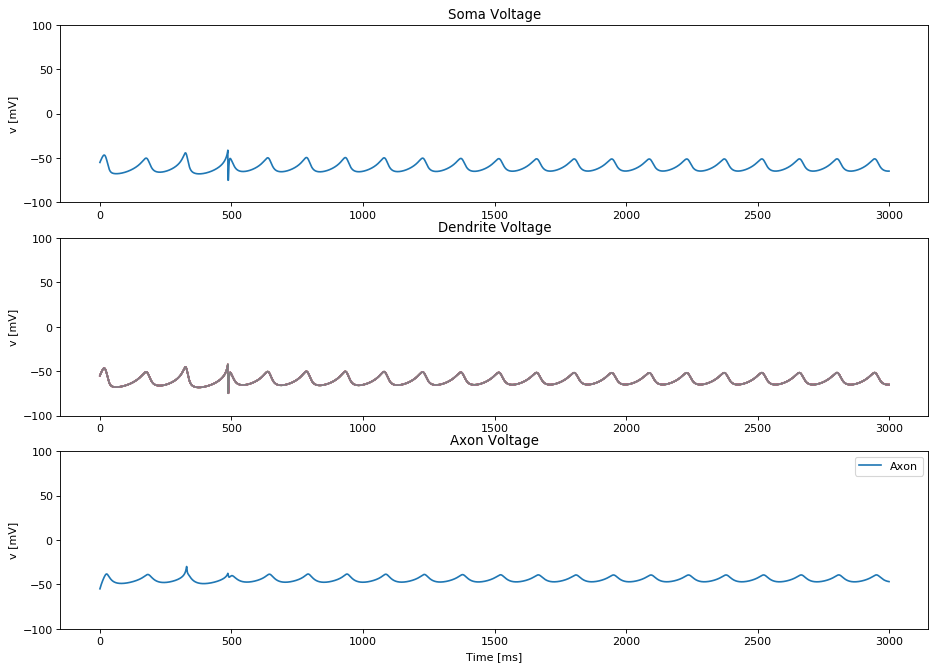

In [188]:
# Conduct a 1D Ca-T type parameter space exploration 

# plot a waterfall that goes from non oscillating to oscillating
restore('IO_setup')

IO = cell_values(IO)
applied_current = 0.15*nA
IO.v = -55.0*mV
IO.Iapp = 0.0*uA

runtime = 3000*ms

#responses = [0.5, 1.4, 1.81, 2.9] #Non-spiking, oscillatory, both spiking and oscillatory, spiking
responses_prot = [29]
for rr in range(0,size(responses_prot)):
  IO.main.g_prot =  responses_prot[rr]*mS/cm**2
  run(runtime)
plot_membrane_potentials_IO(IO_Statemon,num_dendrites)

In [179]:
def plot_Ca_concentrations_IO(IO_Statemon,num_dendrites):
	figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='k')
	plt.subplot(2, 1, 1)
#	for ii in range(0,1):
#	  plot(IO_Statemon.t/ms,IO_Statemon.Ca[ii]/(mM),label='Soma')
#	title('Soma Ca conc')
#	# xlabel('Time [ms]')
#	ylabel('Ca [mM]')
#	ylim([-100,100])
#	plt.subplot(3, 1, 2)
	for ii in range(2,num_dendrites+2):
	  plot(IO_Statemon.t/ms,IO_Statemon.Ca[ii]/(mM),label='Dendrite'+str(ii-1))
	title('Dendrite Ca conc')
	xlabel('Time [ms]')
	ylabel('Ca [mM]')
	ylim([-100,100])
	plt.subplot(3, 1, 3)
    
	plt.plot(IO_Statemon.t/ms, IO_Statemon.k[0]/mV)
	plt.plot(IO_Statemon.t/ms, IO_Statemon.l[0]/mV)
	plt.plot(IO_Statemon.t/ms, IO_Statemon.k_prot[0]/mV)
	plt.plot(IO_Statemon.t/ms, IO_Statemon.l_prot[0]/mV)
	title('Soma Ca gating')
	xlabel('Time [ms]')

#	for ii in range(1,2):
#	  plot(IO_Statemon.t/ms,IO_Statemon.Ca[ii]/(mM),label='Axon')
#	title('Axon Ca conc')
#	xlabel('Time [ms]')
#	ylabel('Ca [mM]')
#	ylim([-100,100])
#	legend()
#	show()
    
    


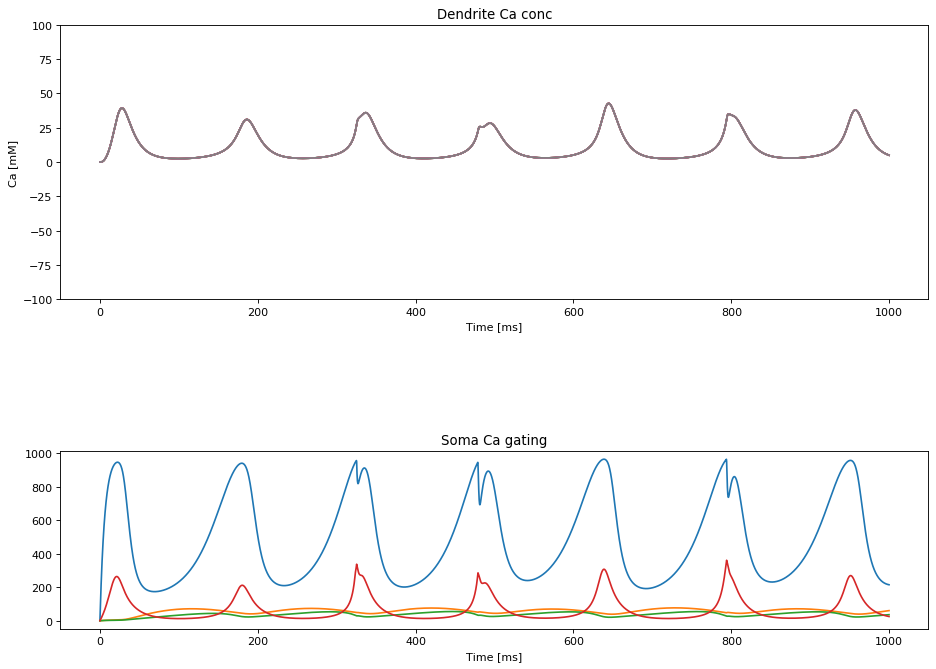

In [180]:
# Conduct a 1D Ca-T type parameter space exploration 

# plot a waterfall that goes from non oscillating to oscillating
restore('IO_setup')

IO = cell_values(IO)
applied_current = 0.15*nA
IO.v = -55.0*mV
IO.Iapp = 0*uA

runtime = 1000*ms

#responses = [0.5, 1.4, 1.81, 2.9]
#responses = [1.4]#Non-spiking, oscillatory, both spiking and oscillatory, spiking
responses = [0.5, 1.5, 1.5, 1.5]
responses_prot = [30]
for rr in range(0,size(responses)):
  IO.main.g_Ca_l =  responses[rr]*mS/cm**2
  

for rr in range(0,size(responses_prot)):
  IO.main.g_prot =  responses_prot[rr]*mS/cm**2
  run(runtime)
    
plot_Ca_concentrations_IO(IO_Statemon,num_dendrites)

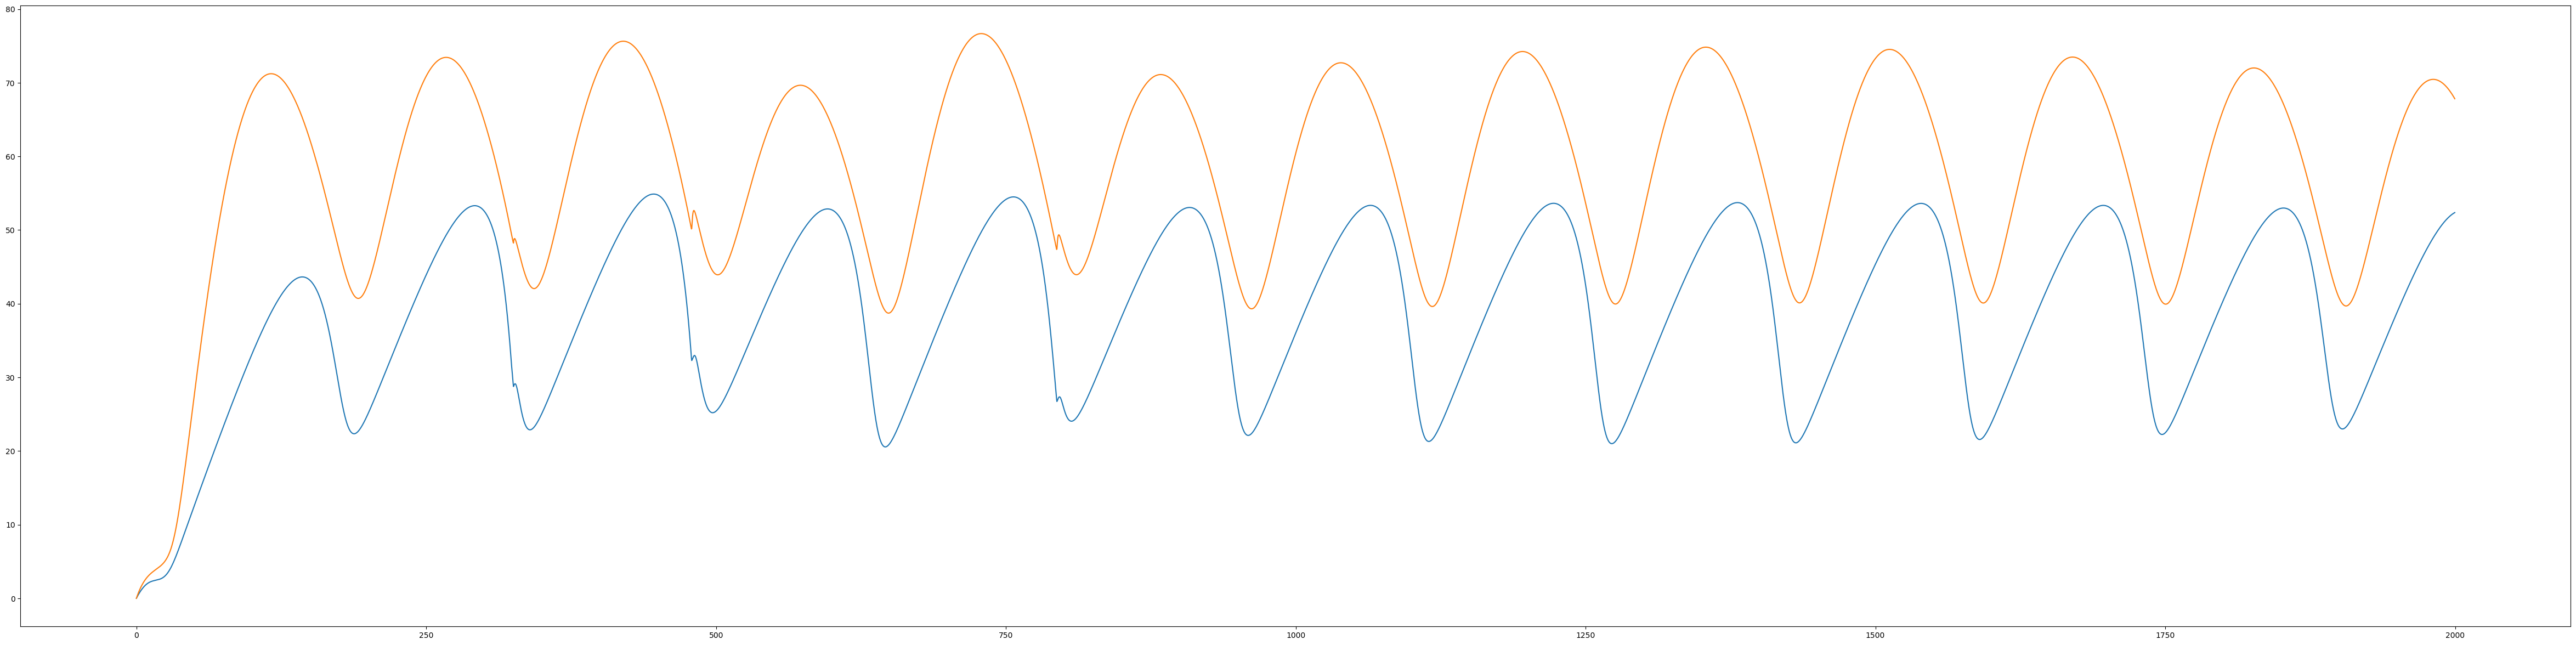

In [174]:
plt.figure(3, figsize=[60,15], dpi=100)
plt.plot(IO_Statemon.t/ms, IO_Statemon.k_prot[0]/mV)
plt.plot(IO_Statemon.t/ms, IO_Statemon.l[0]/mV)

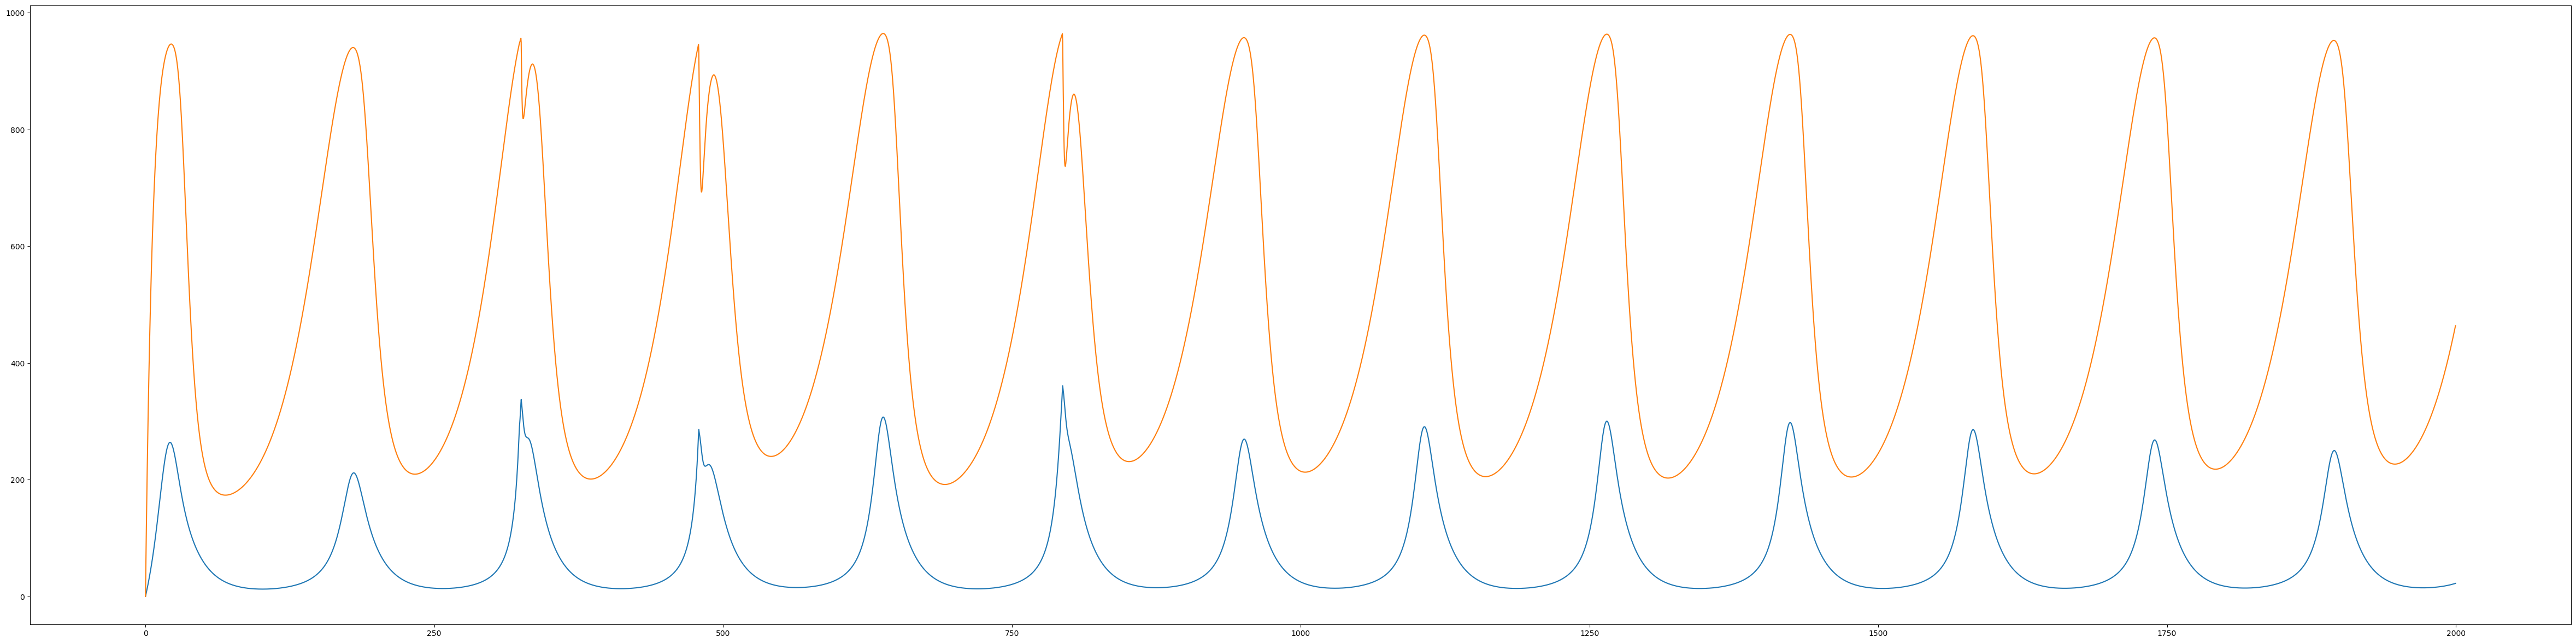

In [175]:
plt.figure(3, figsize=[60,15], dpi=100)
plt.plot(IO_Statemon.t/ms, IO_Statemon.l_prot[0]/mV)
plt.plot(IO_Statemon.t/ms, IO_Statemon.k[0]/mV)


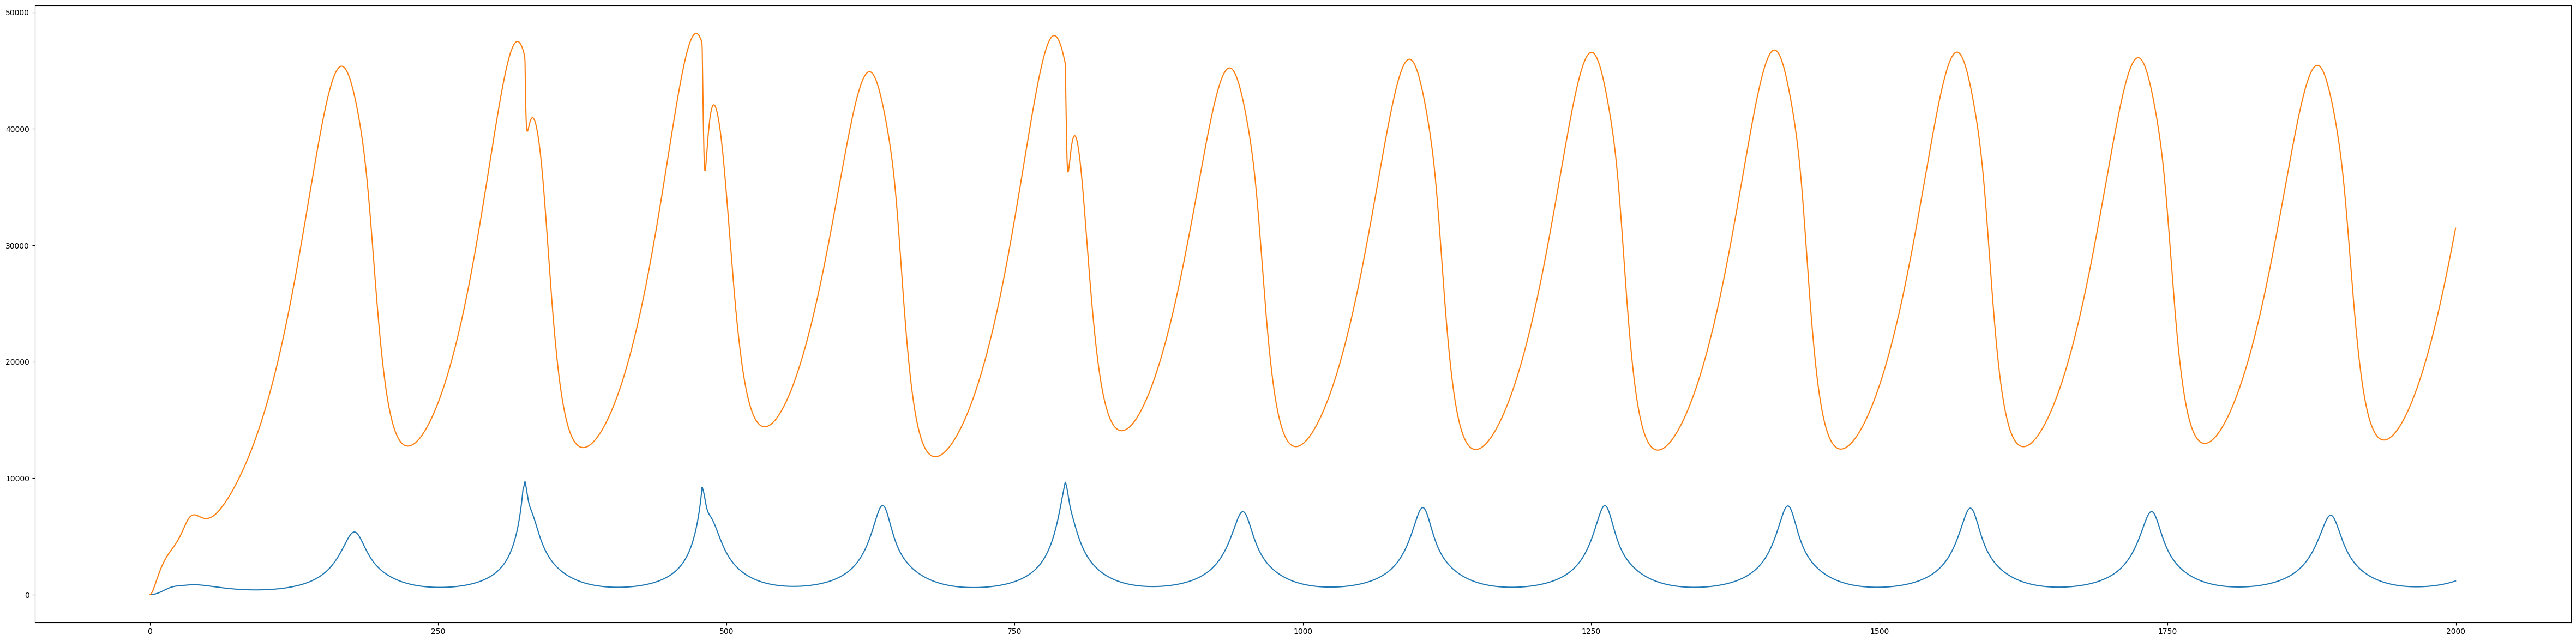

In [176]:
plt.figure(3, figsize=[60,15], dpi=100)
plt.plot(IO_Statemon.t/ms, IO_Statemon.l_prot[0]/mV*IO_Statemon.k_prot[0]/mV)
plt.plot(IO_Statemon.t/ms, IO_Statemon.l[0]/mV*IO_Statemon.k[0]/mV)

Text(0, 0.5, 'I [mA}]')

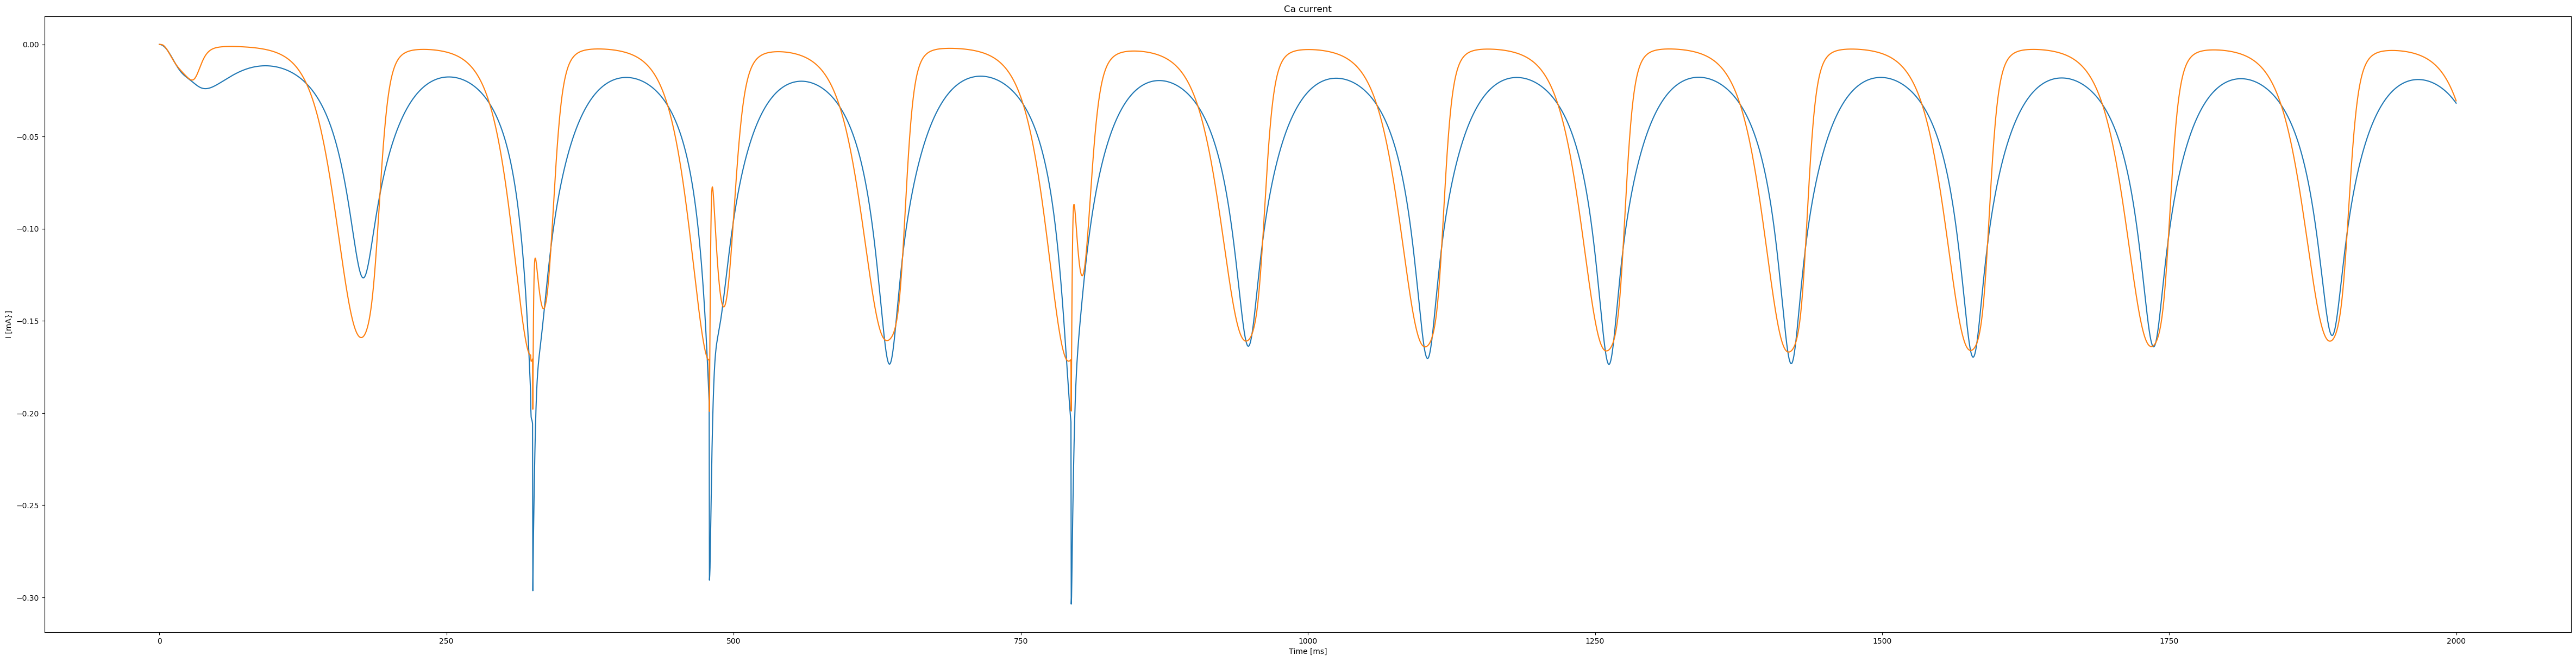

In [177]:
plt.figure(3, figsize=[60,15], dpi=100)
plt.plot(IO_Statemon.t/ms, IO_Statemon.I_prot[0])
plt.plot(IO_Statemon.t/ms, IO_Statemon.I_Ca_l[0])
title('Ca current')
xlabel('Time [ms]')
ylabel('I [mA}]')